**Estude a teoria da PCA para problemas com amostras pequenas**, onde o número de pontos de dados é menor
que a dimensão do espaço de dados (veja [3] ou a seção 12.1.4 de [1]). Escolha um banco de dados de imagens ([6],
por exemplo), converta as imagens para tons de cinza e aplique a teoria de ‘PCA para problemas com amostras pequenas’
para a redução de dimensionalidade.

1. **Seja** x a média amostral (centróide do conjunto de dados) e p1 o componente principal. Visualize o
   resultado da expressão:

   x = x + αp1

   onde α ∈ {−βλ1, 0, βλ1} com λ1 sendo o autovalor associado a p1
   e β um fator escalar (veja [5]).

2. **Estude o espectro da matriz** X^T X para realizar a redução de dimensionalidade. Visualize algumas
   imagens no espaço de dimensão reduzida.

3. **Construa um gerador de imagens** usando os d componentes principais escolhidos no item (2).



In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Carregando conjunto de imagens:

In [2]:
image_dir = './dataset-FEI/frontalimages_spatiallynormalized/'
images = []
image_paths = []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    img = img.resize((260, 360))  
    img_array = np.array(img)
    images.append(img_array)
    image_paths.append(img_path)  

images = np.array(images)
images.shape

(400, 360, 260)

Plotando imagem exemplo:

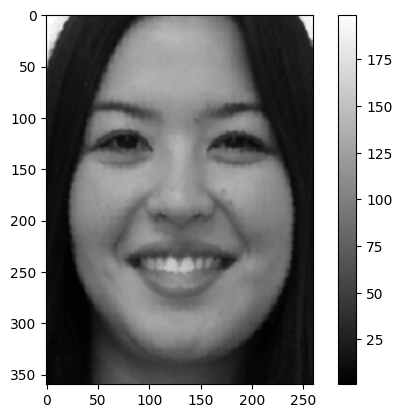

In [3]:
plt.figure()
plt.imshow(images[99], cmap='gray')
plt.colorbar()
plt.grid(False)

Vetorizando imagens:

In [4]:
# achata as imagens em (n_samples, height * width)
images_vetorizada = images.reshape(images.shape[0], -1)
images_vetorizada.shape

(400, 93600)

Calcula a matriz de dados centralizados:

In [5]:
# media global de todos os elementos
global_mean = np.mean(images_vetorizada, axis=0)

# centraliza a matriz de dados
X = images_vetorizada - global_mean

Para o problema de Small size, encontrando autovalores e autovetores de XX^T:

In [6]:
X_T = np.transpose(X)

V = (1/400)*np.dot(X, X_T)

autovalores, autovetoresV = np.linalg.eigh(V)

Multiplica por X^T para encontrar autovetores de S=(1/400)(X^T)X e normaliza.

In [7]:
autovetores = np.dot(X_T, autovetoresV)

autovetores = autovetores / np.linalg.norm(autovetores, axis=0)

autovetores.shape

(93600, 400)

Ordenando em ordem de decrescente em relação aos respectivos autovalores:

In [8]:
ordem_decrescente = np.argsort(autovalores)[::-1]
autovalores = autovalores[ordem_decrescente]
autovetores = autovetores[:, ordem_decrescente]
P_PCA = autovetores
P_PCA.shape

(93600, 400)

Letra a), com coeficiente B = 0.5

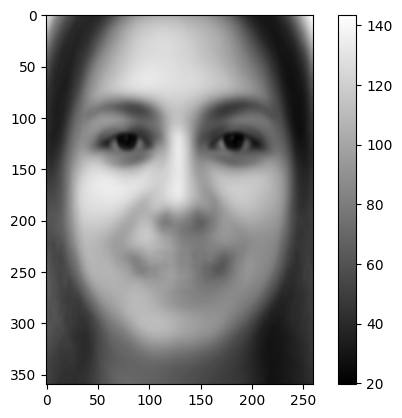

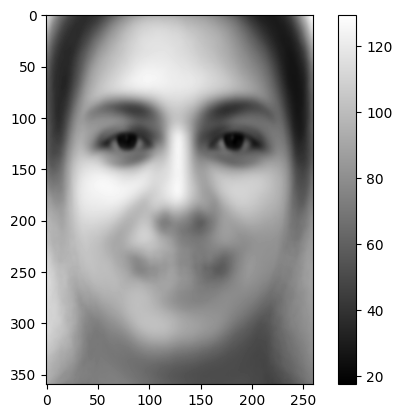

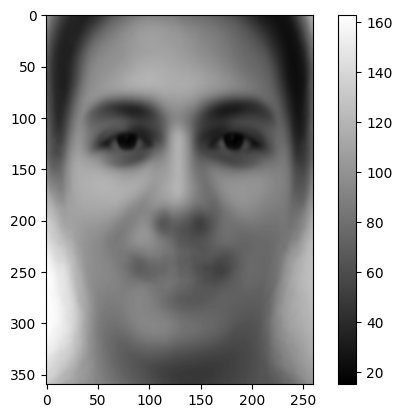

In [9]:
coeficientes = [-0.8,0,0.8]

for i in range(0,3):
    imagem = global_mean + coeficientes[i]*np.sqrt(autovalores[0])*np.transpose(P_PCA[:,0])

    plt.figure()
    plt.imshow(imagem.reshape(360,260), cmap='gray')
    plt.colorbar()
    plt.grid(False)
    plt.show()

Letra b) Análise do espectro da matriz para seleção de truncamento:

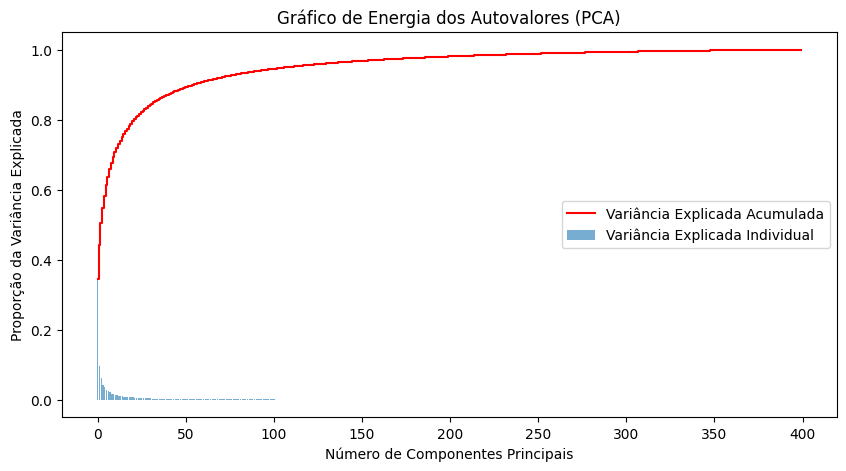

In [10]:
# Passo 1: Calcular a variância explicada
variancia_explicada = autovalores / np.sum(autovalores)

# Passo 2: Calcular a variância explicada acumulada
variancia_explicada_acumulada = np.cumsum(variancia_explicada)

# Passo 3: Plotar o gráfico de energia dos autovalores
plt.figure(figsize=(10, 5))
plt.bar(range(len(variancia_explicada)), variancia_explicada, alpha=0.6, label='Variância Explicada Individual')
plt.step(range(len(variancia_explicada_acumulada)), variancia_explicada_acumulada, where='mid', color='red', label='Variância Explicada Acumulada')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Gráfico de Energia dos Autovalores (PCA)')
plt.legend(loc='best')
plt.show()


Realizando truncamento em 100, criando matriz quadrada de 400x400, mas com até a centésima posição da diagonal com o número 1, e o resto com 0:

In [11]:
trucamento = 100

# cria uma matriz de zeros 400x400
matriz = np.zeros((400, 400))

# define os primeiros 100 elementos da diagonal como 1
np.fill_diagonal(matriz[:trucamento, :trucamento], 1)

P_PCA = np.dot(autovetores, matriz)

P_PCA.shape

(93600, 400)

Projeta o espaço de imagens centralizado X pela matriz P_PCA obtida:

In [12]:
x_PCA = np.dot(X, P_PCA)
x_PCA.shape

(400, 400)

Plota o conjunto das imagens na dimensão obtida pelo P_PCA:

Text(0.5, 1.0, 'PCA - Visualização de Imagens no Espaço das Componentes Principais')

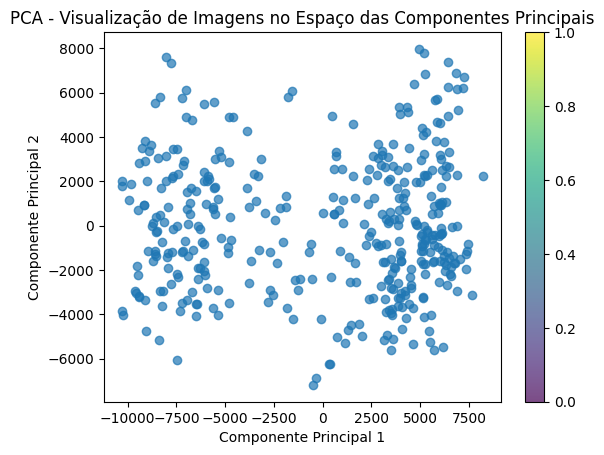

In [13]:
plt.scatter(x_PCA[:, 0], x_PCA[:, 1], alpha=0.7)
plt.colorbar()
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Visualização de Imagens no Espaço das Componentes Principais')


Visualizando imagens após redução de dimensionalidade:

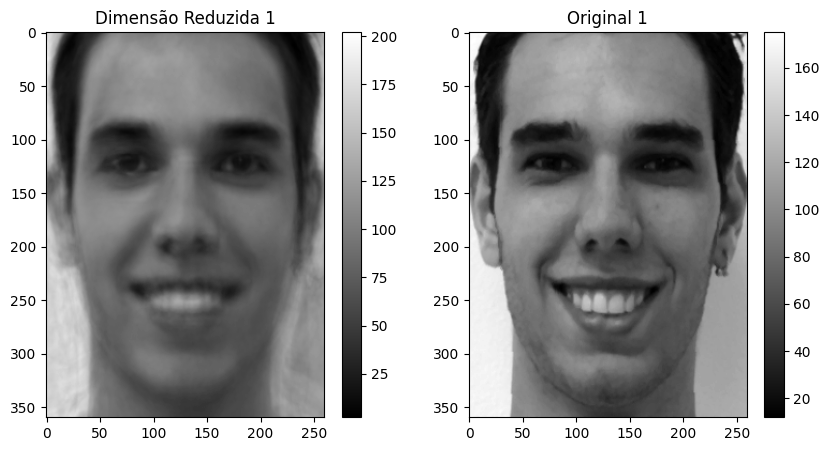

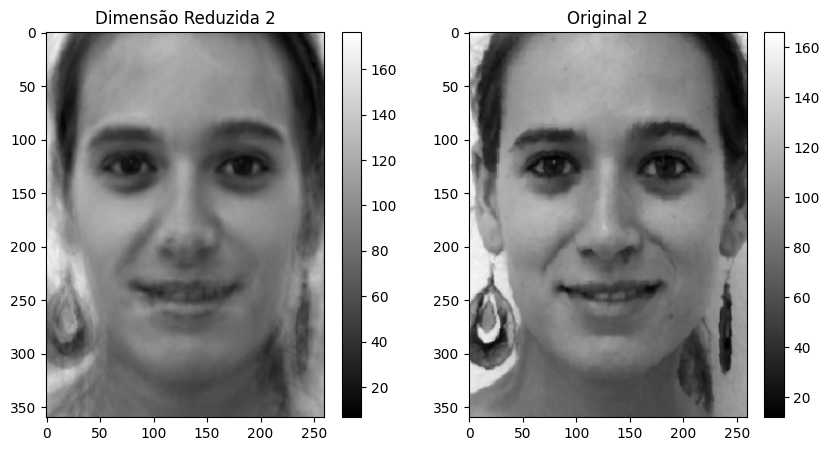

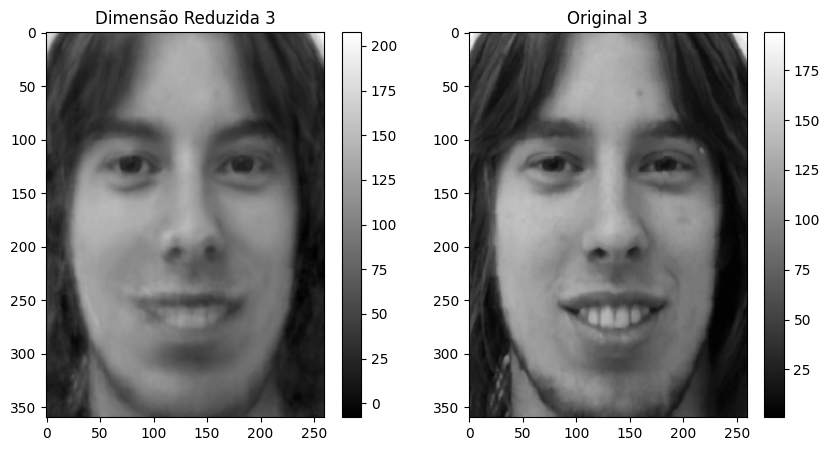

In [14]:
imagem_reduzida = np.dot(x_PCA, np.transpose(P_PCA))+global_mean

import matplotlib.pyplot as plt

for i in range(3):
    plt.figure(figsize=(10, 5)) 

    # Plotar imagem reduzida
    plt.subplot(1, 2, 1)  
    plt.imshow(imagem_reduzida[20*i].reshape(360, 260), cmap='gray')
    plt.title(f'Dimensão Reduzida {i+1}')
    plt.colorbar()
    plt.grid(False)

    # Plotar imagem original
    plt.subplot(1, 2, 2)  
    plt.imshow(images_vetorizada[20*i].reshape(360, 260), cmap='gray')
    plt.title(f'Original {i+1}')
    plt.colorbar()
    plt.grid(False)

    #plt.savefig(f'./outputs/comparacao_imagem_{i+1}.png')
    plt.show()


c) fazendo gerador de imagens:

In [15]:
def image_generator(n_principal_components):
    
    imagem = global_mean

    for i in range(n_principal_components):

        coeficiente = np.random.normal(loc=0, scale=0.1, size=1)

        while coeficiente > 1 or coeficiente < -1:
            coeficiente = np.random.normal(loc=0, scale=0.1, size=1)

        imagem += coeficiente*np.sqrt((np.abs(autovalores[i])))*np.transpose(P_PCA[:,i])

    plt.figure()
    plt.imshow(imagem.reshape(360,260), cmap='gray')
    plt.colorbar()
    plt.grid(False)
    plt.savefig(f'./outputs/gerador.png')
    plt.show()

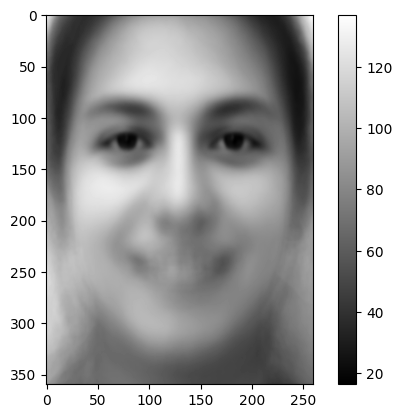

In [16]:
n_principal_components = 100


image_generator(n_principal_components)